# Twitter Sentiment Analysis - POC
---

## 7. SGD with Tfidf


SGD with Tfidf performs very similar if slightly worse than regular BoW representations, so this notebook just proves that it's not worth the effort.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

# SGD takes scaled data
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline

# models
from sklearn.linear_model import SGDClassifier

# evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### Load *X_train_transformed* ($m\approx250k$,  $n=50k$) in Tfidf representation

In [2]:
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_Tfidf_250k_50k.npz"))

In [3]:
X_train_transformed

<251468x50001 sparse matrix of type '<class 'numpy.float64'>'
	with 2569112 stored elements in Compressed Sparse Row format>

### Load y_array with $m\approx250k$

In [4]:
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y = np.load(f)

In [5]:
len(y), y[:10]

(251468, array([1, 1, 0, 0, 1, 1, 0, 0, 1, 0], dtype=int64))

### Stochastic Gradient Descent (SGD)

Chosen because it trains quickly. 

In [6]:
SGD_clf = make_pipeline(
                        StandardScaler(with_mean=False),
                        SGDClassifier(max_iter=1000, 
                                      tol=1e-3, 
                                      loss='hinge', # default, linear SVM, try 'log' for Logistic Regression
                                      warm_start=True,
                                      random_state=42, 
                                      n_jobs=-1)
                       ) 

In [7]:
# achieved 0.7384 with BoW
score = cross_val_score(SGD_clf, X_train_transformed, y, cv=5, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.731, total=  23.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s


[CV] .................................... , score=0.730, total=  25.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.8s remaining:    0.0s


[CV] .................................... , score=0.729, total=  22.9s
[CV]  ................................................................
[CV] .................................... , score=0.734, total=  26.0s
[CV]  ................................................................
[CV] .................................... , score=0.728, total=  24.3s
Mean accuracy: 0.7300730150632915


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


In [8]:
# achieved 0.7406 with BoW
SGD_clf_log = make_pipeline(StandardScaler(with_mean=False),
                            SGDClassifier(max_iter=1000, 
                                          tol=1e-3, 
                                          loss='log', # Logistic Regression
                                          warm_start=True,
                                          random_state=42, 
                                          n_jobs=-1))
score = cross_val_score(SGD_clf_log, X_train_transformed, y, cv=5, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.736, total=  43.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.5s remaining:    0.0s


[CV] .................................... , score=0.733, total=  35.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] .................................... , score=0.736, total=  39.6s
[CV]  ................................................................
[CV] .................................... , score=0.740, total=  38.0s
[CV]  ................................................................
[CV] .................................... , score=0.735, total=  44.9s
Mean accuracy: 0.7359783456434853


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [9]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more data points
    data_granularity = int(X_train.shape[0]/10)
    
    xs, train_acc, valid_acc = [], [], []

    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

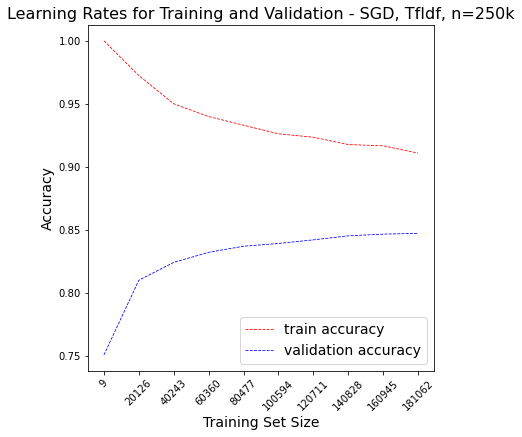

In [10]:
plot_learning_curves_feed_m(SGD_clf, X_train_transformed, y, 
                           'SGD, TfIdf, n=250k')

Compared to the BoW curves:

<img src="../plots/Fig1_LearningRate_SGD_BoW_n250k.PNG" alt="BoW" width="500" style="float:left"/>

I'm not convinced it's worth the time to preprocess the entire dataset since these two tests indicate Tfidf performs worse with SGD.

---